In [1]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib
import matplotlib.pyplot as plt
from abc import abstractmethod
from typing import List, Callable, Union, Any, TypeVar, Tuple
from itertools import cycle
Tensor = TypeVar('torch.tensor')

import os
import math

import numpy as np
import scipy.io as scio
from torch import optim, nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from tqdm import tqdm

from torchvision import transforms
import torchvision.utils as vutils


# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

#import plotly.express as px
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,  completeness_score, v_measure_score
from scipy.optimize import linear_sum_assignment

import onlineVDP_suff_stat

In [2]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  2.2.2


In [3]:
class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [4]:
class DP_VAE(BaseVAE):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 dpmm_param: dict,
                 hidden_layers: list,
                 output_type: str='linear',
                 **kwargs) -> None:
        
        super(DP_VAE, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dpmm_param = dpmm_param
        self.output_type = output_type
        # the parameters of the DPGMM model
        self.current_result = {}
        self.current_suff_stat = {}
        self.opts = onlineVDP_suff_stat.mkopts_vdp(**dpmm_param)
        self.prior = {}

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers[1], hidden_layers[2]),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(hidden_layers[2], latent_dim)
        self.fc_log_var = nn.Linear(hidden_layers[2], latent_dim)

        # Build Decoder

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_layers[2]),
            nn.ReLU(),
            nn.Linear(hidden_layers[2], hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers[1], hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers[0], self.input_dim)
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network and returns the latent codes.
        param input: (Tensor) Input tensor to encoder [N x C x H x W]
        return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        mu = self.fc_mu(result)
        log_var = self.fc_log_var(result)
        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes onto the image space.
        param z: (Tensor) [B x D]
        return: (Tensor) [B x C x H x W]
        """

        result = self.decoder(z)

        if self.output_type == 'linear':
            pass
        elif self.output_type == 'sigmoid':
            result = torch.sigmoid(result)
        else: # tahn
            result = torch.tanh(result)

        return result
    
    def reparameterize(self, mu: Tensor, log_var: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu  
      
    # Forward propagation: inference network outputs mu(x) and log_var(x) given an input x, then use repameterization trick to sample a batch of z, which are feed to DPGMM model
    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var, z] # [recon, input, mu, log_var, z]

    def reconstruction(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input sample x, returns the reconstructed sample
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

    def fit_dpmm(self, z):
        # use the lanter variables z of the entire dataset to fit the DPGMM model
        # for the DPGMM, the dimension of input is D*N, while for the VAE, the dimension of input is N*D
        z = z.detach().cpu().t()
        prior = onlineVDP_suff_stat.mk_hp_prior(z, **self.dpmm_param)
        #self.prior = prior
        current_result = onlineVDP_suff_stat.online_vdpgmm_suffstat(z, prior, self.opts, move_dict_to_device(self.current_result, z.device))
        self.current_result = current_result
        self.current_suff_stat = current_result['sum_stat']
        current_K = self.current_result['K']

        self.calc_cluster_component_params()
        
    def calc_cluster_component_params(self):
        # expected value of mean vector and covariance matrix of each gaussian component in the DPGMM

        # means and covariance matrices
        self.comp_mu = [self.current_result['hp_posterior']['m'][:,k] for k in range(self.current_result['K']-1)]
        self.comp_var = [torch.inverse(self.current_result['hp_posterior']['lambda'][:,k]*self.current_result['hp_posterior']['W'][:,:,k]) for k in range(self.current_result['K']-1)]
        print("Log: current K", self.current_result['true_K']) # ignore the additional component
        
    # we use the entire set of lantent variables z to fit the DPGMM model, but when calculating the loss, we only use a batch of data
    # the cluster_assignments function outputs the responsibility and the hard assignments of the data in the batch

    # Backprop: calculate the loss function
    # loss = reconstruction loss + KL divergence   
    def loss_function(self,
                    *args,
                    batch_size,
                    batch_idx,
                    kl_weight) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2] # u(z|x)
        log_var = args[3] # sigma(z|x)
        z = args[4]  # batch_size * latent_dim

        # reconstruction loss
        recons_loss = F.mse_loss(recons, input, reduction='sum')

        # calculate kl divergence
        kld_weight = kl_weight # Account for the minibatch samples from the dataset
        # kl_weight = batch_size/size of the entire training set,

        #estimate the DPGMM
        if len(self.current_result) == 0:
            kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            loss = recons_loss + kld_weight * kld_loss
            # prior = onlineVDP_suff_stat.mk_hp_prior(z.detach().cpu().t(), **self.dpmm_param)
            # self.prior = prior
            # var = torch.exp(0.5 * log_var)**2
            # # batch_shape [batch_size], event_shape [latent_dim]
            # dist = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(var))

            
            # covariance = torch.inverse(self.prior['lambda0']*self.prior['W0'])

            # dist_k = torch.distributions.MultivariateNormal(loc=self.prior['m0'].squeeze().to(mu.device), covariance_matrix=torch.diag_embed(torch.diag(covariance)).to(mu.device))
            # expanded_dist_k = dist_k.expand(dist.batch_shape)
            # kld = torch.distributions.kl_divergence(dist, dist_k) 
            # kld_loss = torch.mean(kld)  
            # #kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            # loss = recons_loss + kld_weight * kld_loss
            return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z}
        
        else:
            #prob_comps --> responsibilities, comps --> Z[n] cluster assignments 
            #soft assignment and hard assignment
            prob_comps, comps = self.cluster_assignments(z.detach().cpu()) # soft assignment N*K real_K = q_of_z.shape[1]-1
            #print(f"num_q_of_z:{self.current_posterior['q_of_z'].shape[1]}")
            #_ , comps = torch.max(prob_comps, dim=1) # comps: hard assignment, size = K

            # get a distribution of the latent variables
            var = torch.exp(0.5 * log_var)**2
            # batch_shape [batch_size], event_shape [latent_dim]
            dist = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(var))  # distribution of z obtained from the encoder

            # get a distribution for each cluster
            B, K = prob_comps.shape # batch_shape (number of samples in the current minibatch), number of active clusters
            #print("Log: B, K", B, K)
            #print("Log: prob_comps", prob_comps.shape)
            kld = torch.zeros(B).to(mu.device)

            for k in range(K):
            # batch_shape [], event_shape [latent_dim]

            # responsibility to the kth component
                prob_k = prob_comps[:, k] # size = B, responsibility of the kth component
                dist_k = torch.distributions.MultivariateNormal(loc=self.comp_mu[k].to(mu.device), covariance_matrix=torch.diag_embed(torch.diag(self.comp_var[k]).to(mu.device))) # use diagonal covariance matrix here

            # batch_shape [batch_size], event_shape [latent_dim]

            # mini_batch 中每个zi都服从一个对应的multivariate normal分布zi - N(u(zi|xi),sigma(zi|xi))), 所以一共batch_size个multivariate normal分布
            # 它们分别与第k个component，即N(uk,sigmak)求KL-divergence，再取平均，得到batch的 KL loss

                expanded_dist_k = dist_k.expand(dist.batch_shape) # 把第k个component复制batch_shape次，再以tensor的形式一起计算KL divergence

                kld_k = torch.distributions.kl_divergence(dist, expanded_dist_k)   #  shape [batch_shape, ]

                #print(f"prob_k_shape:{prob_k.shape}, kld_k_shape:{kld_k.shape}")

                kld += prob_k.to(mu.device) * kld_k

        # 最终的 KL loss是minibatch中每个sample的KL loss的平均
        kld_loss = torch.mean(kld)

        loss = recons_loss + kld_weight * kld_loss
        loss = loss.to(input.device)
        return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z, 'comps': comps}

    def cluster_assignments(self, z):
        # z: batch_size * latent_dim --> z.t(): latent_dim * batch_size
        q_of_z, _, _ = onlineVDP_suff_stat.mk_q_of_z(z.t(), self.current_result['hp_posterior'], self.current_result['hp_prior'], self.opts)
        # Here, responsibility is a 2D array of size N x K. here N is batch size, K active clusters
        # Each entry resp[n, k] gives the probability that data atom n is assigned to cluster k under the posterior.
        resp = q_of_z[:,:-1]
        # To convert to hard assignments
        Z = resp.argmax(axis=1)
        return resp, Z

torch.Size([2000, 1000])
number of total classes: 8


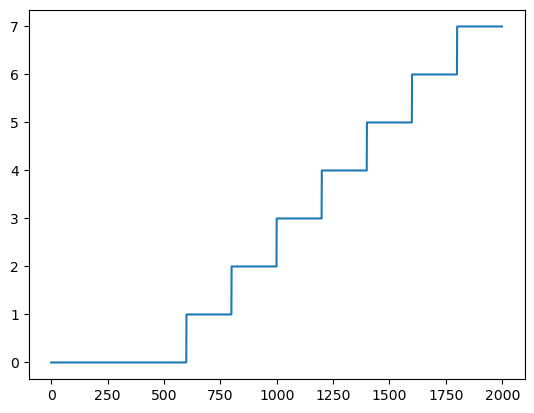

In [9]:
batch_size = 32
seed = 12345
torch.manual_seed(seed)  # ensure reproducible results

'''use a numerical dataset to test the model
label  damaged_floor     damage_extent         number_of_samples
0           0            0%                     600
1           1            5%                     200
2           1            10%                    200
3           2,4          10%, 10%               200
4           1,3,5        10%,15%,20%            200
5           2,4,6        15%,20%,25%            200
6           1,3,5,7      10%,15%,20%,25%        200
7           1,2,4,6,8    10%,15%,20%,25%,30%    200

'''
# Read data from CSV
features = pd.read_csv("toy_dataset.csv")
features = features.astype("float32")
# # # Convert DataFrame to PyTorch tensors
X = torch.tensor(features.values[:,:1000])
# scaler = StandardScaler()
# X =  torch.tensor(scaler.fit_transform(X)).detach().float()

input_dim = X.shape[1]
print(X.shape)

y0 = torch.tensor(features.values[:,1000])
y0 = y0.unsqueeze(1)
y = [int(_) for _ in y0] #+ 0.01*y0.mean()*torch.randn(y0.shape[0], 1)
y = torch.tensor(y)
num_classes = y.max().item() + 1
print(f"number of total classes: {num_classes}")

# create datasets for each class (for incremental learning)
datasets = [TensorDataset(X[y==i], y[y==i]) for i in range(num_classes)]

# use the dataset with 5 classes initially
init_dataset = ConcatDataset(datasets[:1])
current_dataset = init_dataset

train_size = int(0.8 * len(current_dataset))
test_size = int(0.1 * len(current_dataset))
valid_size = len(current_dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

# Accessing the tensors from train_dataset and test_dataset
# x_train, y_train = train_dataset[:]
# x_valid, y_valid = valid_dataset[:]
# # Optionally, you can also access the test set
# x_test, y_test = test_dataset[:]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

plt.plot(y)
plt.show()

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
latent_dim = 10
model_params = dict(
    input_dim = input_dim,
    latent_dim = latent_dim,
    hidden_layers = [500, 500, 2000],
    dpmm_param = dict(
        alpha=torch.tensor(10.0),
        beta0=torch.tensor(0.01),
        max_iter_merge = 10,
        max_iter_split = 3,
        max_merge = 10,
        max_split = 5,
        ite = 100,
    )
)

# MLP format
model = DP_VAE(**model_params).to(device)
print(model.state_dict)

cuda
<bound method Module.state_dict of DP_VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=2000, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=2000, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=1000, bias=True)
  )
)>


In [12]:
def move_dict_to_device(state_dict, device):
    '''move all tensors in state_dict to the device'''
    new_state_dict = {}
    for k, v in state_dict.items():
        if isinstance(v, torch.Tensor):
            new_state_dict[k] = v.to(device)
        else:
            new_state_dict[k] = v
    return new_state_dict

def forward(model, input: Tensor, **kwargs) -> Tensor:
    return model(input, **kwargs)
    
    
def training_step(model, batch_samples, batch_labels, batch_idx, kl_weight):
    curr_device = batch_samples.device

    batch_size = batch_samples.size(0)
    results = forward(model, batch_samples, labels = batch_labels)
    train_loss = model.loss_function(*results, batch_size = batch_size, batch_idx = batch_idx,
                                              kl_weight = kl_weight,
                                              )
    #for name, metric in train_loss.items():
        #if "loss" in name:
            #log("train_" + name, metric.mean().item(), on_step=False, on_epoch=True, prog_bar=True)

    train_loss.update({'labels': batch_labels})
    #print(f"train_loss:{train_loss}")
    return train_loss    # latent encoding

def training_epoch_end(model, current_epoch, total_epochs, dpmm_init_epoch, outputs):
    if current_epoch >= dpmm_init_epoch:
        z = torch.cat([outputs[i]['z'] for i in range(0, len(outputs))])
        model.fit_dpmm(z)
    
    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        #comps = np.array([outputs[i]['comps'] for i in range(0, len(outputs))]).flatten()
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        #print(f"labels:{labels}")
        #print(f"comps:{comps}")
        acc, assignment_training = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        mapping = {}
        try:
            for i,j in assignment_training:
                mapping[i] = j
            training_mapped_labels = [mapping[i] for i in comps.numpy()]
        except:
            training_mapped_labels = labels.numpy().astype(int)

        dda_training = damage_detection_acc(labels.numpy().astype(int), np.array(training_mapped_labels))
        #self.log("train_clustering_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        #self.log("Number_of_DP_Comps", int(self.model.bnp_model.obsModel.K), on_step=False, on_epoch=True, prog_bar=True)
        print(f"train_clustering_acc:{acc}", f"train_ars:{ars}", f"train_nmi:{nmi}", f"train_dda: {dda_training}")
        print(f"Number_of_DP_Comps:{model.current_result['true_K']}")
        print(f"Nk:{model.current_result['sum_stat']['Nk']}")

        return comps, labels, acc, dda_training[0]
    
def validation_step(model, batch_samples, batch_labels, batch_idx, kl_weight):
    batch_size = batch_samples.size(0)
    results = forward(model, batch_samples, labels = batch_labels)
    val_loss = model.loss_function(*results, batch_size = batch_size, batch_idx = batch_idx, kl_weight = kl_weight)
                                        
    val_loss.update({'labels': batch_labels})
    
    return val_loss

def validation_epoch_end(current_epoch, total_epochs, outputs):
    
    print(f"====================== Validation Epoch: {current_epoch+1} ========================")

    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        acc, assignment_valid = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        mapping = {}
        try:
            for i,j in assignment_valid:
                mapping[i] = j
            valid_mapped_labels = [mapping[i] for i in comps.numpy()]
        except:
            valid_mapped_labels = labels.numpy().astype(int)

        dda_val = damage_detection_acc(labels.numpy().astype(int), np.array(valid_mapped_labels))

        print(f"valid_clustering_acc:{acc}", f"valid_ars:{ars}", f"valid_nmi:{nmi}", f"valid_dda: {dda_val}")
        return acc, dda_val[0]
    
def test_epoch(current_epoch, total_epochs, outputs):
    
    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        acc, assignment_test = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        mapping = {}
        try:
            for i,j in assignment_test:
                mapping[i] = j
            test_mapped_labels = [mapping[i] for i in comps.numpy()]
        except:
            test_mapped_labels = labels.numpy().astype(int)

        dda_test = damage_detection_acc(labels.numpy().astype(int), np.array(test_mapped_labels))

        print(f"test_clustering_acc:{acc}", f"test_ars:{ars}", f"test_nmi:{nmi}", f"test_dda: {dda_test}")
        return acc, dda_test[0]
        
def unsupervised_clustering_accuracy(y: Union[np.ndarray, torch.Tensor], y_pred: Union[np.ndarray, torch.Tensor]) -> tuple:
        """Unsupervised Clustering Accuracy
        """
        assert len(y_pred) == len(y)
        u = np.unique(y)
        n_true_clusters = len(u)
        v = np.unique(y_pred)
        n_pred_clusters = len(v)
        map_u = dict(zip(u, range(n_true_clusters)))
        map_v = dict(zip(v, range(n_pred_clusters)))
        inv_map_u = {v: k for k, v in map_u.items()}
        inv_map_v = {v: k for k, v in map_v.items()}
        r = np.zeros((n_pred_clusters, n_true_clusters), dtype=np.int64)
        for y_pred_, y_ in zip(y_pred, y):
            if y_ in map_u:
                r[map_v[y_pred_], map_u[y_]] += 1
        reward_matrix  = np.concatenate((r, r, r), axis=1)
        cost_matrix = reward_matrix.max() - reward_matrix
        row_assign, col_assign = linear_sum_assignment(cost_matrix)

        # Construct optimal assignments matrix
        row_assign = row_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        col_assign = col_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        assignments = np.concatenate((row_assign, col_assign), axis=1)
        assignments = [[inv_map_v[x], inv_map_u[y%n_true_clusters]] for x, y in assignments]

        optimal_reward = reward_matrix[row_assign, col_assign].sum() * 1.0
        return optimal_reward / y_pred.size, assignments       

In [13]:
def damage_detection_acc(y, y_pred):
    y = y.astype(int)
    y_pred = y_pred.astype(int)
    
    fn = 0
    fp = 0
    most_tru = np.bincount(y).argmax()
    #most_pre = 3
    most_pre = np.bincount(y_pred).argmax()


    for i in range(len(y)):
        if y[i] == most_tru and y_pred[i] != most_pre:
            fp += 1
        if y[i] != most_tru and y_pred[i] == most_pre:
            fn += 1
        dda = 1 - (fn + fp) / len(y)        
    return dda, fn, fp

current_epoch 0/301: 100%|██████████| 15/15 [00:00<00:00, 22.76it/s]


training_loss:3549.0030 reconstruction_loss:3548.9897 kl_loss:0.0133
### greedy splitting ###
free_energy not decreased after splitting
F=5470.7;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
torch.Size([480, 10])


current_epoch 1/301: 100%|██████████| 15/15 [00:00<00:00, 83.53it/s]


training_loss:2514.7383 reconstruction_loss:2514.5504 kl_loss:0.1878
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=5985.6;    Nk=[459.66, 20.34, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 2 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:1729.1984 val_reconstruction_loss:1729.0735 val_kl_loss:0.1249


current_epoch 2/301: 100%|██████████| 15/15 [00:00<00:00, 98.61it/s]

training_loss:1339.6893 reconstruction_loss:1339.4589 kl_loss:0.2304
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###


free_energy not decreased after splitting
F=6370.9;    Nk=[453.24, 26.76, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 3 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:888.3788 val_reconstruction_loss:888.3578 val_kl_loss:0.0209


current_epoch 3/301: 100%|██████████| 15/15 [00:00<00:00, 37.36it/s]


training_loss:717.0684 reconstruction_loss:717.0381 kl_loss:0.0302
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###
free_energy not decreased after splitting
F=6238.3;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 4 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:543.0182 val_reconstruction_loss:542.9834 val_kl_loss:0.0348


current_epoch 4/301: 100%|██████████| 15/15 [00:00<00:00, 103.71it/s]

training_loss:525.4941 reconstruction_loss:525.4518 kl_loss:0.0423
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###


free_energy not decreased after splitting
F=6045.1;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 5 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:514.6502 val_reconstruction_loss:514.5963 val_kl_loss:0.0539


current_epoch 5/301: 100%|██████████| 15/15 [00:00<00:00, 99.92it/s] 

training_loss:485.7815 reconstruction_loss:485.7156 kl_loss:0.0659
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###


free_energy not decreased after splitting
F=6002.4;    Nk=[480.00, 0.00];
merge step is not implemented
Log: current K 1
train_clustering_acc:1.0 train_ars:1.0 train_nmi:1.0 train_dda: (1.0, 0, 0)
Number_of_DP_Comps:1
Nk:tensor([[480.,   0.]])
====================== Validation Epoch: 6 ========================
valid_clustering_acc:1.0 valid_ars:1.0 valid_nmi:1.0 valid_dda: (1.0, 0, 0)
valid_loss:448.6968 val_reconstruction_loss:448.6208 val_kl_loss:0.0760


current_epoch 6/301: 100%|██████████| 15/15 [00:00<00:00, 41.26it/s]


training_loss:461.7156 reconstruction_loss:461.6247 kl_loss:0.0909
test_clustering_acc:1.0 test_ars:1.0 test_nmi:1.0 test_dda: (1.0, 0, 0)
### greedy splitting ###


KeyboardInterrupt: 

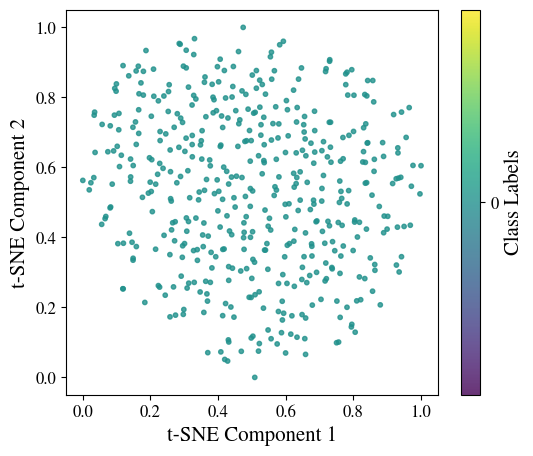

In [14]:
optimizer = optim.Adam(model.parameters(), lr = 5e-5, weight_decay = 0)

# total_epoch拟合DPGMM-训练vae 这一循环的epoch
total_epochs = 301
dpmm_init_epoch = 0

training_loss_epoch = []
recon_loss_epoch = []
kl_loss_epoch = []

val_loss_epoch = []
val_recon_loss_epoch = []
val_kl_loss_epoch = []

training_acc_epoch = []
val_acc_epoch = []
test_acc_epoch = []

dda_training_epoch = []
dda_val_epoch = []
dda_test_epoch = []


y_ground_truth = torch.tensor([])

add_epochs = [40,80,190]
plot_epochs = [i for i in np.arange(0, 301, 10)]

for epoch in range(total_epochs):
    # set train_loader, test_loader, and valid_loader conditioned on current epoch
    
    
    if epoch == add_epochs[0]:
        new_class1 =  1
        new_class2 = 2
        current_dataset = ConcatDataset([current_dataset, datasets[new_class1], datasets[new_class2]])
    
        train_size = int(0.8 * len(current_dataset))
        test_size = int(0.1 * len(current_dataset))
        valid_size = len(current_dataset) - train_size - test_size
        train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    elif epoch == add_epochs[1]:
        new_class1 =  3
        new_class2 =  4
        current_dataset = ConcatDataset([current_dataset, datasets[new_class1], datasets[new_class2]])
    
        train_size = int(0.8 * len(current_dataset))
        test_size = int(0.1 * len(current_dataset))
        valid_size = len(current_dataset) - train_size - test_size
        train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    elif epoch == add_epochs[2]:
        new_class1 =  5
        new_class2 =  6
        new_class3 =  7
        current_dataset = ConcatDataset([current_dataset, datasets[new_class1], datasets[new_class2], datasets[new_class3]])
    
        train_size = int(0.8 * len(current_dataset))
        test_size = int(0.1 * len(current_dataset))
        valid_size = len(current_dataset) - train_size - test_size
        train_dataset, test_dataset, valid_dataset = random_split(current_dataset, [train_size, test_size, valid_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    kl_weight = 1 # batch_size/len(train_loader.dataset)
    pbar = tqdm(train_loader, desc=f"current_epoch {epoch}/{total_epochs}")
        # training_loss_batch只记录training loss (total loss)
    training_loss_batch = []
    recon_loss_batch = []
    kl_loss_batch = []
        # train_loss_batch = [] 将一个epoch中所有mini_batch数据训练得出的loss存入一个列表, 包括 total loss， reconstruction loss， kl loss,‘z’,'components'
    train_loss_batch = []
    batch_idx = 0

    for batch_samples, batch_labels in pbar:

        if epoch == total_epochs - 1:
            y_ground_truth = torch.cat([y_ground_truth, batch_labels])

        batch_samples = batch_samples.to(device)

        train_loss = training_step(model, batch_samples, batch_labels, batch_idx, kl_weight)
        train_loss_batch.append(train_loss)
        

        # total loss in of a minibatch
        training_loss = train_loss['loss']
        training_loss_batch.append(train_loss['loss'].item())
        recon_loss_batch.append(train_loss['reconstruction_loss'].item())
        kl_loss_batch.append(kl_weight*train_loss['kld_loss'].item())


        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        batch_idx += 1


    #training_loss_epoch.append(np.mean(training_loss_batch)/batch_size)
    recon_loss_epoch.append(np.mean(recon_loss_batch))
    kl_loss_epoch.append(np.mean(kl_loss_batch))
    training_loss_epoch.append(recon_loss_epoch[epoch]+kl_loss_epoch[epoch])

    print(f"training_loss:{np.mean(training_loss_batch):.4f}", f"reconstruction_loss:{np.mean(recon_loss_batch):.4f}", f"kl_loss:{np.mean(kl_loss_batch):.4f}")

    if "comps" in train_loss_batch[0]:
        test_loss_batch = []
        batch_idx_test = 0
        
        for batch_samples, batch_labels in test_loader:
            batch_samples = batch_samples.to(device)
            test_loss = validation_step(model, batch_samples, batch_labels, batch_idx_test, kl_weight = 1)# batch_size/len(valid_loader.dataset))
            test_loss_batch.append(test_loss)
            batch_idx_test += 1

        test_acc, dda_test = test_epoch(epoch, total_epochs, test_loss_batch)
        test_acc_epoch.append(test_acc)
        dda_test_epoch.append(dda_test)
        

    if "comps" in train_loss_batch[0]:
        comps0, labels0, training_acc, dda_training = training_epoch_end(model, epoch, total_epochs, dpmm_init_epoch, train_loss_batch)
        training_acc_epoch.append(training_acc)
        dda_training_epoch.append(dda_training)

    else:
        training_epoch_end(model, epoch, total_epochs, dpmm_init_epoch, train_loss_batch)

    #if epoch > 0:
    with torch.no_grad():

        val_loss_batch = []
        valid_loss_batch = []
        val_recon_loss_batch = []
        val_kl_loss_batch = []
        batch_idx_val = 0

        for batch_samples, batch_labels in valid_loader:

            batch_samples = batch_samples.to(device)
            val_loss = validation_step(model, batch_samples, batch_labels, batch_idx_val, kl_weight = 1) #batch_size/len(valid_loader.dataset))
            val_loss_batch.append(val_loss)

            valid_loss_batch.append(val_loss['loss'].item())
            val_recon_loss_batch.append(val_loss['reconstruction_loss'].item())
            val_kl_loss_batch.append(kl_weight*val_loss['kld_loss'].item())

            batch_idx_val += 1
        
        #val_loss_epoch.append(np.mean(valid_loss_batch)/batch_size)
        val_recon_loss_epoch.append(np.mean(val_recon_loss_batch))
        val_kl_loss_epoch.append(np.mean(val_kl_loss_batch))
        val_loss_epoch.append(val_recon_loss_epoch[epoch]+val_kl_loss_epoch[epoch])

        if "comps" in train_loss_batch[0]:
            val_acc, dda_val = validation_epoch_end(epoch, total_epochs, val_loss_batch)
            val_acc_epoch.append(val_acc)
            dda_val_epoch.append(dda_val)
            print(f"valid_loss:{np.mean(valid_loss_batch):.4f}", f"val_reconstruction_loss:{np.mean(val_recon_loss_batch):.4f}", f"val_kl_loss:{np.mean(val_kl_loss_batch):.4f}")

    if epoch in plot_epochs:
        latent_variables = torch.tensor([])
        for i in range(len(train_loss_batch)): 
            latent_variables = torch.cat([latent_variables,train_loss_batch[i]['z'].cpu()],dim=0)
            
        print(latent_variables.shape)

        preds = model.current_result['hard_assign']
        # Create a random dataset with 6 dimensions and 2000 samples
        data = latent_variables.detach().cpu().numpy()
        # Create random labels for 6 classes
        labels = preds.squeeze()

        # Convert to tensors
        #data_tensor = torch.tensor(data, dtype=torch.float32)
        #labels_tensor = torch.tensor(labels, dtype=torch.int64)

        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=seed)
        tsne_results = tsne.fit_transform(data)
        tsne_max, tsne_min = tsne_results.max(0), tsne_results.min(0)
        tsne_results =  (tsne_results - tsne_min) / (tsne_max - tsne_min)

        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        matplotlib.rcParams['font.family'] = 'STIXGeneral'
        size_ = 15
        plt.rc('figure', titlesize=size_)  # fontsize of the figure title
        plt.rc('axes', titlesize=size_)  # fontsize of the axes title
        plt.rc('axes', labelsize=size_)  # fontsize of the x and y labels
        plt.rc('xtick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('ytick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('legend', fontsize=size_*0.8)  # legend fontsize
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors += ['#db8233', '#8c564b', '#e377c2', "#8eab12"]
        # Plotting
        plt.figure(figsize=(6, 5))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.8, s=10)
        plt.colorbar(scatter, ticks=range(np.max(labels.detach().numpy())+1), label='Class Labels')
        #plt.title('t-SNE of the latent space with assigned clusters')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plot_name = 'numerical_t-SNE_preds epoch ' + str(epoch) + '.png'
        plt.savefig(plot_name)
        #plt.show()

    if epoch == total_epochs - 1:
        latent_variables = torch.tensor([])
        for i in range(len(train_loss_batch)): 
            latent_variables = torch.cat([latent_variables,train_loss_batch[i]['z'].cpu()],dim=0)
            
        print(latent_variables.shape)
        data = latent_variables.detach().cpu().numpy()

        tsne = TSNE(n_components=2, random_state=seed)
        tsne_results = tsne.fit_transform(data)
        tsne_max, tsne_min = tsne_results.max(0), tsne_results.min(0)
        tsne_results =  (tsne_results - tsne_min) / (tsne_max - tsne_min)

        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        matplotlib.rcParams['font.family'] = 'STIXGeneral'
        size_ = 15
        plt.rc('figure', titlesize=size_)  # fontsize of the figure title
        plt.rc('axes', titlesize=size_)  # fontsize of the axes title
        plt.rc('axes', labelsize=size_)  # fontsize of the x and y labels
        plt.rc('xtick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('ytick', labelsize=size_*0.8)  # fontsize of the tick labels
        plt.rc('legend', fontsize=size_*0.8)  # legend fontsize
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors += ['#db8233', '#8c564b', '#e377c2', "#8eab12"]
        # Plotting
        plt.figure(figsize=(6, 5))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_ground_truth.squeeze().int(), cmap='viridis', alpha=0.8, s=10)
        plt.colorbar(scatter, ticks=range(np.max(y_ground_truth.squeeze().int().detach().numpy())+1), label='Class Labels')
        #plt.title('t-SNE of the latent space with groundtruth labels')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plot_name1 = 'numerical_t-SNE_ground_truth epoch ' + str(epoch) + '.png'
        plt.savefig(plot_name1)
        

        

Text(0, 0.5, 'Unsupervised Clustering Accuracy')

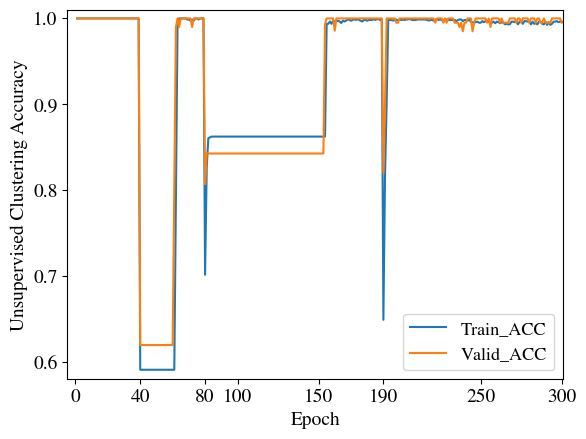

In [11]:
fig, ax = plt.subplots()
font= {'fontweight': 100, 'fontsize': 14}
x = [i for i in np.arange(1,len(training_acc_epoch)+1)]
ax.plot(x, training_acc_epoch[:])
ax.plot(x, val_acc_epoch[:])

ax.set_xticks([0, 40, 80, 100, 150, 190, 250, 300], labels = [0, 40, 80, 100, 150, 190, 250, 300], fontsize=14)
ax.set_yticks(np.arange(0.5,1.01,0.1), labels = [0.5,0.6,0.7,0.8,0.9,1.0], fontsize=14)
ax.set_xlim(-5,301)
ax.set_ylim(0.58,1.01)
#ax.plot(x, test_acc_epoch[:])
ax.legend(['Train_ACC', 'Valid_ACC'], fontsize=13)
ax.set_xlabel('Epoch', fontdict=font)
ax.set_ylabel('Unsupervised Clustering Accuracy',fontdict=font)
#plt.savefig('numerical_incremental_acc.png')

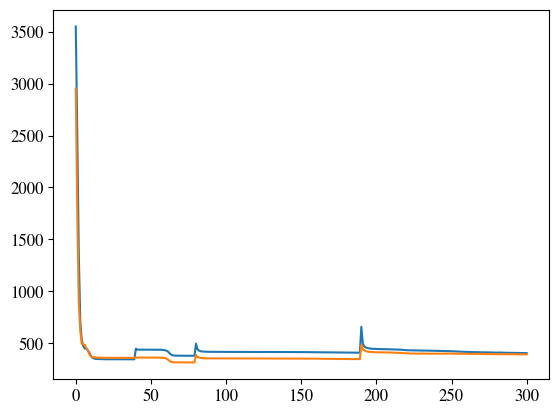

In [12]:
fig, ax = plt.subplots()
ax.plot(np.array(training_loss_epoch[:]))
ax.plot(np.array(val_loss_epoch[:]))

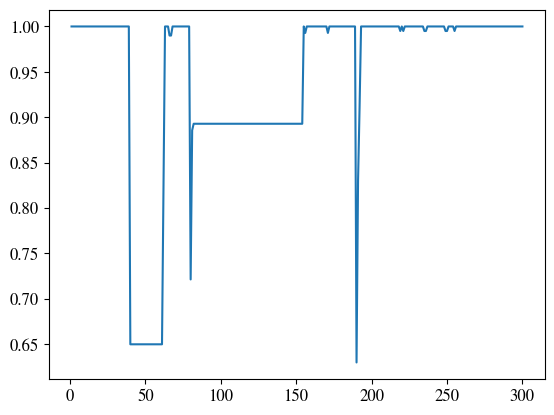

In [13]:
fig, ax = plt.subplots()
x = [i for i in np.arange(1,len(training_acc_epoch)+1)]
#ax.plot(training_acc_epoch[:])
#ax.plot(val_acc_epoch[:])
ax.plot(x, test_acc_epoch[:])

torch.Size([1600, 10])
(0.994375, 1, 8) 0.9875 0.9279453649900657 0.948865579692645


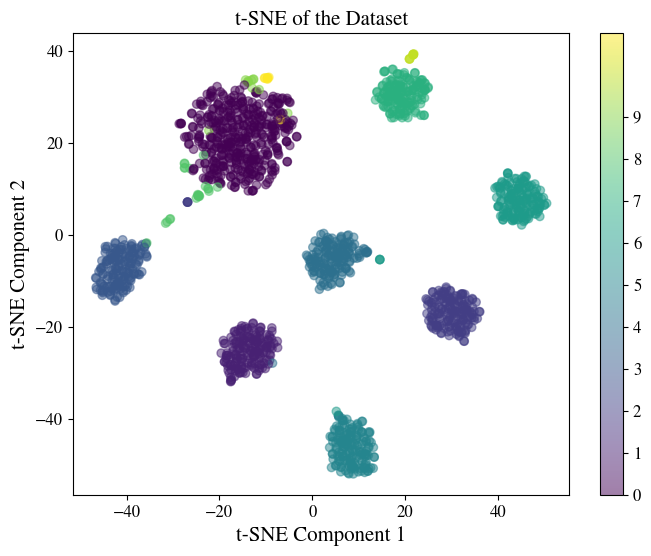

In [14]:
# Create a random dataset with 6 dimensions and 2000 samples
np.random.seed(12345)
latent_variables = torch.tensor([])
for i in range(len(train_loss_batch)): 
    latent_variables = torch.cat([latent_variables,train_loss_batch[i]['z'].cpu()],dim=0)
    
print(latent_variables.shape)

preds = model.current_result['hard_assign']

#  clustering accuracy of the training set
acc_training, assignment_training = unsupervised_clustering_accuracy(y_ground_truth.numpy().astype(int), preds.numpy())
ars_training = adjusted_rand_score(y_ground_truth.numpy().astype(int), preds.numpy())
nmi_training = normalized_mutual_info_score(y_ground_truth.numpy().astype(int), preds.numpy())

mapping = {}
try:
    for i,j in assignment_training:
        mapping[i] = j
    training_mapped_labels = [mapping[i] for i in preds.numpy()]
except:
    training_mapped_labels = y_ground_truth.numpy().astype(int)

dda_training = damage_detection_acc(y_ground_truth.numpy().astype(int), np.array(training_mapped_labels))
print(dda_training, acc_training, ars_training, nmi_training)
data = latent_variables.detach().cpu().numpy()
# Create random labels for 6 classes
labels = preds.squeeze()

# Convert to tensors
#data_tensor = torch.tensor(data, dtype=torch.float32)
#labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

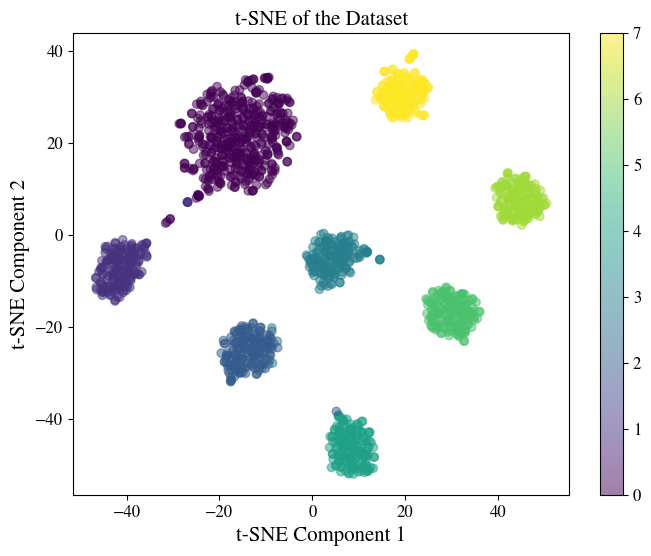

In [15]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_ground_truth.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

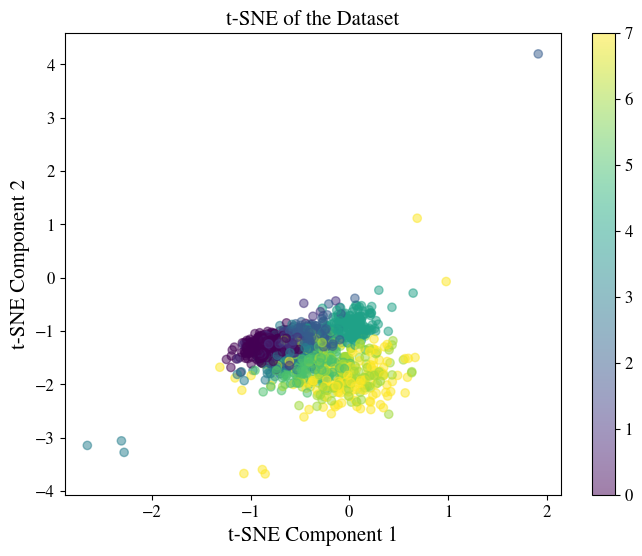

In [16]:
plt.figure(figsize=(8, 6))
data = latent_variables.detach().cpu().numpy()
labels = preds.squeeze()
scatter = plt.scatter(data[:, 0], data[:, 2], c=y_ground_truth.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [17]:
y_valid = torch.tensor([])
for batch_samples, batch_labels in valid_loader:
    y_valid = torch.cat([y_valid, batch_labels], dim=0)

latent_val = torch.tensor([])
preds_val = torch.tensor([])
for i in range(len(val_loss_batch)): 
    latent_val = torch.cat([latent_val,val_loss_batch[i]['z'].cpu()],dim=0)
    preds_val = torch.cat([preds_val,val_loss_batch[i]['comps'].cpu()],dim=0)

acc_valid, assignment_valid = unsupervised_clustering_accuracy(y_valid.numpy().astype(int), preds_val.numpy())
ars_valid = adjusted_rand_score(y_valid.numpy().astype(int), preds_val.numpy())
nmi_valid = normalized_mutual_info_score(y_valid.numpy().astype(int), preds_val.numpy())

mapping = {}
try:
    for i,j in assignment_valid:
        mapping[i] = j
    valid_mapped_labels = [mapping[i] for i in preds_val.numpy()]
except:
    valid_mapped_labels = y_valid.numpy().astype(int)

dda_valid = damage_detection_acc(y_valid.numpy().astype(int), np.array(valid_mapped_labels))

print(dda_valid, acc_valid, ars_valid, nmi_valid)

(1.0, 0, 0) 0.995 0.9683042130871922 0.972468145937556


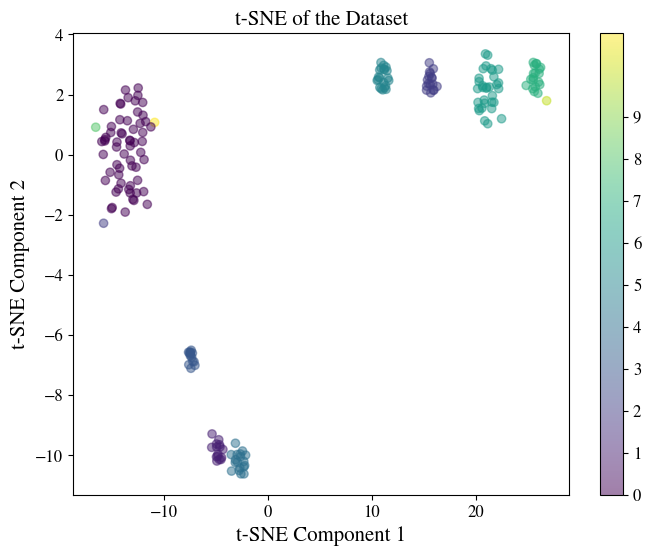

In [18]:
data = latent_val.detach().cpu().numpy()
# Create random labels for 6 classes
labels = preds_val.squeeze()

# Convert to tensors
#data_tensor = torch.tensor(data, dtype=torch.float32)
#labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [19]:
y_test = torch.tensor([])
for batch_samples, batch_labels in test_loader:
    y_test = torch.cat([y_test, batch_labels], dim=0)

latent_test = torch.tensor([])
preds_test = torch.tensor([])
for i in range(len(test_loss_batch)): 
    latent_test = torch.cat([latent_test,test_loss_batch[i]['z'].cpu()],dim=0)
    preds_test = torch.cat([preds_test,test_loss_batch[i]['comps'].cpu()],dim=0)


acc_test, assignment_test = unsupervised_clustering_accuracy(y_test.numpy().astype(int), preds_test.numpy())
ars_test = adjusted_rand_score(y_test.numpy().astype(int), preds_test.numpy())
nmi_test = normalized_mutual_info_score(y_test.numpy().astype(int), preds_test.numpy())


mapping = {}
try:
    for i,j in assignment_test:
        mapping[i] = j
    test_mapped_labels = [mapping[i] for i in preds_test.numpy()]
except:
    test_mapped_labels = y_test.numpy().astype(int)

dda_test = damage_detection_acc(y_test.numpy().astype(int), np.array(test_mapped_labels))

print(dda_test, acc_test, ars_test, nmi_test)

final_dda = (dda_training[0]*train_size + dda_valid[0]*valid_size + dda_test[0]*test_size) / len(current_dataset)
print(f'final dda: {final_dda}')
print(test_mapped_labels)
print(y_test.numpy().astype(int))

(1.0, 0, 0) 1.0 0.9533754548641602 0.9771014169485602
final dda: 0.9955
[1, 4, 7, 5, 7, 4, 4, 7, 0, 0, 5, 2, 5, 0, 7, 4, 4, 0, 1, 2, 3, 0, 1, 7, 6, 5, 0, 5, 6, 6, 0, 4, 0, 5, 1, 2, 4, 0, 0, 2, 1, 7, 4, 2, 0, 0, 4, 0, 1, 1, 5, 7, 0, 7, 0, 5, 4, 1, 5, 0, 7, 4, 6, 0, 0, 6, 0, 3, 0, 2, 4, 7, 7, 3, 0, 1, 0, 0, 7, 7, 0, 3, 3, 5, 4, 5, 3, 7, 1, 7, 2, 2, 0, 6, 0, 4, 6, 3, 4, 0, 7, 5, 4, 0, 6, 0, 5, 0, 0, 0, 0, 3, 5, 6, 5, 6, 0, 1, 4, 0, 3, 0, 0, 0, 2, 2, 0, 0, 1, 6, 3, 0, 5, 0, 0, 7, 0, 2, 0, 0, 2, 7, 0, 5, 2, 5, 6, 5, 0, 4, 6, 1, 6, 6, 3, 0, 3, 1, 0, 0, 7, 1, 0, 2, 2, 0, 0, 0, 3, 7, 2, 1, 0, 0, 5, 4, 5, 0, 0, 0, 6, 7, 7, 0, 0, 3, 0, 0, 5, 5, 4, 0, 0, 2, 0, 3, 1, 2, 0, 6]
[1 4 7 5 7 4 4 7 0 0 5 2 5 0 7 4 4 0 1 2 3 0 1 7 6 5 0 5 6 6 0 4 0 5 1 2 4
 0 0 2 1 7 4 2 0 0 4 0 1 1 5 7 0 7 0 5 4 1 5 0 7 4 6 0 0 6 0 3 0 2 4 7 7 3
 0 1 0 0 7 7 0 3 3 5 4 5 3 7 1 7 2 2 0 6 0 4 6 3 4 0 7 5 4 0 6 0 5 0 0 0 0
 3 5 6 5 6 0 1 4 0 3 0 0 0 2 2 0 0 1 6 3 0 5 0 0 7 0 2 0 0 2 7 0 5 2 5 6 5
 0 4 6 1 6 6 3 0 3 1 0 0 7 

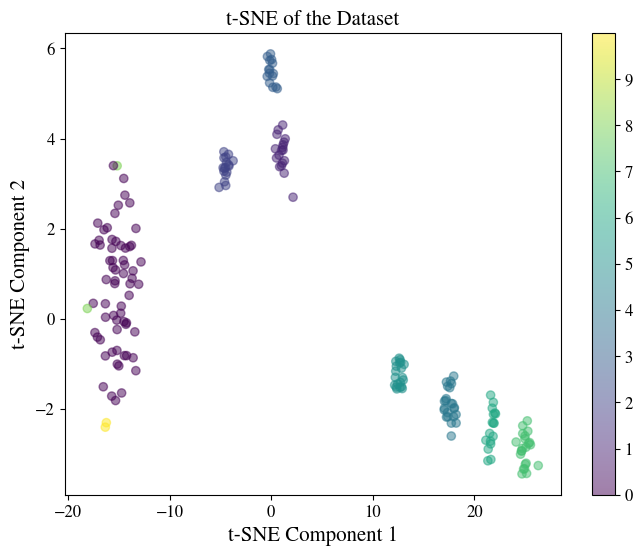

In [20]:
data = latent_test.detach().cpu().numpy()
# Create random labels for 6 classes
labels = preds_test.squeeze()

# Convert to tensors
#data_tensor = torch.tensor(data, dtype=torch.float32)
#labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.squeeze().int(), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of the Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()